## <h3 align="center">Statistical Analysis and Modeling of Neural Data (NEU 560)</h3>

<h4 align="center">Princeton University, Spring 2024</h4>

---

## Homework 3: Generalized Linear Models (GLM)

#### Due: Friday, 3/29 at 11:59pm

#### <b>Student's 3-digit Class Number</b>: <i>255</i>

---


---

### Formatting & Submission Instructions

- Please prepare your homework submission completely within your own copy of this colab notebook.

- For each problem or sub-problem, please **limit yourself to one Code cell and/or one Markdown cell** as appropriate (switch between them by using the menu at the top, or the shortcuts `Esc + M` for Markdown and `Esc + Y` for Code). Of course, feel free to use as many cells as you like in the course of working on the homework, just clean and condense once you're done!

- **Comments**: Comments within code cells can be useful for explaining your code and thought process as necessary (anything following a `#` is a comment in Python; you can quickly (un)comment blocks of code by highlighting it and using the shortcut `Cmd + /`. See the posted solution for Homework 0 for examples of the desired formatting).

- **Grading**: All problems or sub-problems are worth 1pt each unless otherwise marked.

- **Submitting your homework**: Please submit by sending an _editable_ link to your notebook, via an email to Victor (vg0233@princeton.edu). We are going to use anonymous grading, so PLEASE PUT YOUR STUDENT # IN THE APPROPRIATE FIELD ABOVE BEFORE SUBMITTING.

- **Test before submmitting**: Before submitting, make sure to verify that your code runs without errors by selecting `Runtime -> Restart & Run All`.


---

Before we start let's import some of our favorite packages.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
### Download data

!wget https://github.com/pillowlab/neu560data/blob/master/RGCdata.mat?raw=true
!wget https://github.com/pillowlab/neu560data/blob/master/RGCdataHi.mat?raw=true
# Rename raw files with the mv utility
!mv RGCdata.mat\?raw\=true RGCdata.mat
!mv RGCdataHi.mat\?raw\=true RGCdataHi.mat

zsh:1: no matches found: https://github.com/pillowlab/neu560data/blob/master/RGCdata.mat?raw=true
zsh:1: no matches found: https://github.com/pillowlab/neu560data/blob/master/RGCdataHi.mat?raw=true
mv: RGCdata.mat?raw=true: No such file or directory
mv: RGCdataHi.mat?raw=true: No such file or directory


---

## Load some binned spike train data from primate retina

Load the file `RGCdata.mat`, which contains temporal binary white noise stimuli and the binned spike responses of 4 retinal ganglion cells (RGCs) recorded from a small patch of retina in vitro. [Ref: Uzzell & Chichilnisky 2004]. It contains three variables:

$\quad \bullet$ `Stim` = a $T=144051 \times 1$ vector of full-filed stimulus intensities for a stimulus presented at approximately 120Hz (120 Frames per second), a stimulus commonly known as "full-field flicker".

$\quad \bullet$ `SpCounts` = a $144051 \times 4$ matrix of binned spike counts (each column has counts for a different cell: 2 ON cells, 2 OFF cells).

$\quad \bullet$ `dtStim` = the size of a single time bin (in seconds), needed for computing model output in units of spikes / s. The stimulus frame raate is given by 1/dtStim.


In [9]:
#Read in the variables from pdfData2D.mat
from scipy.io import loadmat
data = loadmat('RGCdata.mat')
Stim = data['Stim']
SpCounts = data['SpCounts']
dtStim = data['dtStim']


In [10]:
dtStim

array([[0.0083406]])

In [11]:
Stim.shape

(144051, 1)

## Fit linear-Gaussian regression Model

**1)** Create the design matrix $X$ using $d=25$ time bins of the stimulus for each row. That is, $X$ should be a $T \times d$ matrix, where each row is the relevant stimulus vector for predicting the response of a neuron on that trial. Assume values of `Stim`=0 for the 24 time bins prior to the first time bin of the response. (This is known as "zero-padding", so that the design matrix has the same number of rows as the response vectors in `SpCounts`.) Make an image plot showing the first 50 rows of the design matrix (i.e., a $50 \times 25$ matrix).


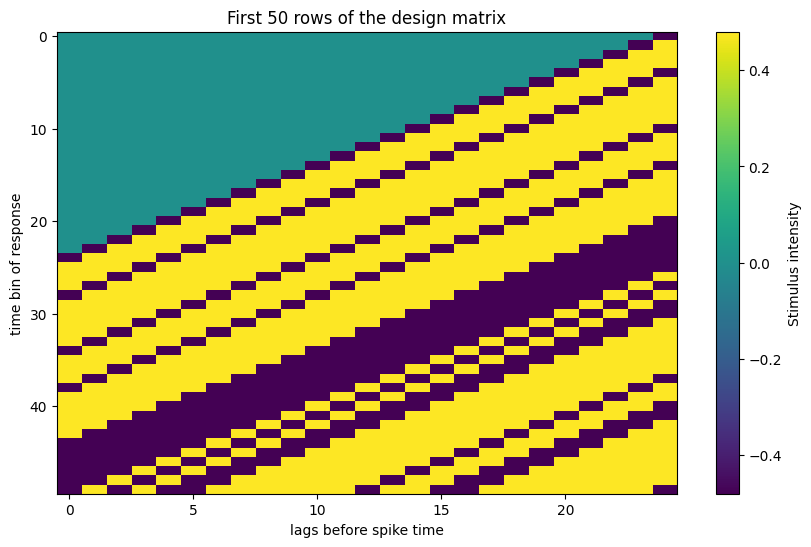

In [12]:
# zero padding
Stim_padded = np.vstack((np.zeros((24,1)), Stim))

# create design matrix
X = Stim_padded[0:len(Stim)]
for i in range(1, 25):
    X = np.hstack((X, Stim_padded[i:len(Stim)+i]))
    
# Plot the first 50 rows of the design matrix
plt.figure(figsize=(10, 6))
plt.imshow(X[:50, :], aspect='auto', cmap='viridis')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar(label='Stimulus intensity')
plt.title('First 50 rows of the design matrix')
plt.show()

**2)** For neuron 1, compute the spike-triggered average, $STA = X^T Y \,/\, \textrm{sum}(Y)$, where $Y$ is the vector of spike counts of the neuron (i.e., the first column of `SpCounts`)


In [13]:
STA = X.T @ SpCounts[:, 0] / np.sum(SpCounts[:, 0])
print(f"spike-triggered average for neuron 1: {STA}")

spike-triggered average for neuron 1: [ 2.52727734e-03 -3.09058615e-03 -4.00405988e-03 -3.63867039e-03
  1.26363867e-03  6.34864248e-03  1.08855620e-02  2.18472469e-02
  2.50444050e-02  3.77721391e-02  5.30271505e-02  6.42628774e-02
  7.61380360e-02  8.55468155e-02  9.96447602e-02  1.00071048e-01
  8.03400152e-02  4.96472976e-02  4.18523217e-02  1.48439482e-02
 -2.35904593e-01 -4.39639685e-01 -2.99375793e-01 -5.01497082e-02
  2.13143872e-04]


**3)** For the same neuron, compute the maximum likelihood estimate for the linear-Gaussian GLM (aka "general linear model").

Before you do so, add a column of 1's to the design matrix, so that your weights are augmented to include an additive constant (also known as a "DC term"). This additional weight, which we will refer to as $b$, will account for the mean of $Y$ (which is not zero, since the spike counts are all $\geq 1$).

Plot the resulting ML filter estimate (just the 25-element weight vector $w$ on the stimulus elements, not the DC term $b$), after rescaling it to be a unit vector. Plot the STA (also rescaled to be a unit vector) on the same axes. How much difference is there between the STA and the ML estimate?


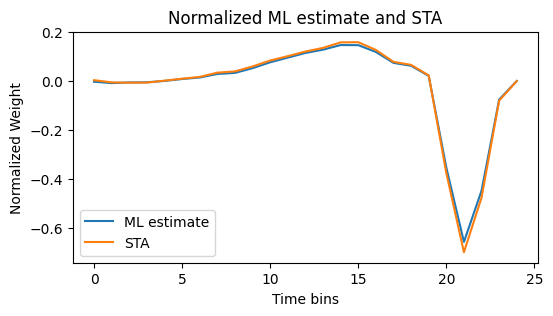

Difference between the STA and the ML estimate: 0.06182811629601531


In [14]:
# Add a column of ones to the design matrix
X_augmented = np.hstack((X, np.ones((X.shape[0], 1))))

# Compute the maximum likelihood estimate for the linear-Gaussian GLM
# aka least squares
Y = SpCounts[:, 0]
w = np.linalg.inv(X_augmented.T @ X_augmented) @ X_augmented.T @ Y

# Rescale the ML filter estimate and the STA to be unit vectors
w_rescaled = w / np.linalg.norm(w)
STA_rescaled = STA / np.linalg.norm(STA)

# Plot the rescaled ML filter estimate and the STA
plt.figure(figsize=(6, 3))
plt.plot(w_rescaled[:-1], label='ML estimate')
plt.plot(STA_rescaled, label='STA')
plt.xlabel('Time bins')
plt.ylabel('Normalized Weight')
plt.legend()
plt.title('Normalized ML estimate and STA')
plt.show()

difference = np.linalg.norm(STA_rescaled - w_rescaled[:-1])
print(f"Difference between the STA and the ML estimate: {difference}")

# There is relatively little difference between STA and ML estimate.

## Poisson GLM

**4)** Write a function to compute negative log-likelihood of the spike train under the Poisson-GLM with exponential nonlinearity. Your function should take in the weights $w$, the spike train $Y$, the design matrix $X$, and the weights $w$ and compute $-\log P(Y|X,w)$.


In [15]:
def neg_log_likelihood(w, Y, X):
    z = dtStim*np.exp(X @ w)
    return -np.sum(Y * np.log(z) - z)

**5)** Use `scipy.optimize` to find the maximum-likelihood estimate of the weight vector $w$ under the Poisson GLM, using the function you wrote in the previous problem. Be sure to use the design matrix augmented with a column of 1s so that your model includes an additive constant.

Plot the filter estimate on the same axes as the STA and linear-Gaussian model estimate (with all three vectors rescaled to be unit vectors, so that we aren't distracted by differences in their amplitude).


In [16]:
import numpy as np
from scipy.optimize import minimize

# Initial guess for w
w0 = np.zeros(X_augmented.shape[1])

# Use scipy.optimize.minimize to find w that minimizes neg_log_likelihood
result = minimize(neg_log_likelihood, w0, args=(Y, X_augmented))

# The maximum-likelihood estimate for w is stored in result.x
w_mle = result.x

In [17]:
Y.shape

(144051,)

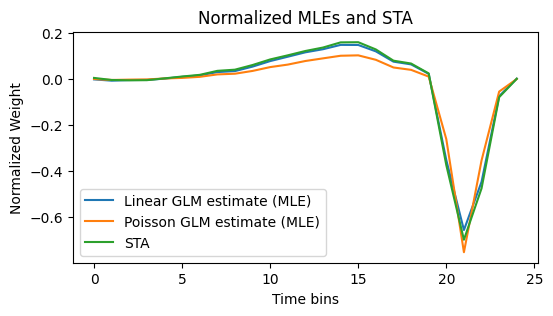

In [10]:
# Plot the rescaled ML filter estimate and the STA

w_mle_rescaled = w_mle / np.linalg.norm(w_mle)

plt.figure(figsize=(6, 3))
plt.plot(w_rescaled[:-1], label='Linear GLM estimate (MLE)')
plt.plot(w_mle_rescaled[:-1], label='Poisson GLM estimate (MLE)')
plt.plot(STA_rescaled, label='STA')
plt.xlabel('Time bins')
plt.ylabel('Normalized Weight')
plt.legend()
plt.title('Normalized MLEs and STA')
plt.show()

**6)** Now write a second function to compute the negative log-likelihood for the Poisson GLM that uses the nonlinearity $f(x) = \log(1+\exp(x))$. This function grows linearly for large positive $x$ but decays slowly to 0 for negative $x$, and is therefore known as the "soft-rectification" function, or alternately as the "soft-plus function". You can simply alter your function above, or else write a more general function that takes in the nonlinearity as on of the arguments.

Use `scipy.optimize` to find the maximum-likelihood estimate of the weight vector $w$ and constant $b$ under this second Poisson GLM. Which model (with exponential or soft-plus nonlinearity) achieves higher log-likelihood (or equivalently, lower negative log-likelihood)? Plot the two Poisson-GLM filter estimates on the same axes.


In [24]:
def neg_log_likelihood_softplus(w, Y, X):
    z = dtStim * np.log1p(np.exp(X @ w))
    return -np.sum(Y * np.log(z) - z)

In [25]:
import numpy as np
from scipy.optimize import minimize

w_mle_softplus = np.zeros(X_augmented.shape[1])

# Use scipy.optimize.minimize to find w that minimizes neg_log_likelihood
result = minimize(neg_log_likelihood_softplus, w_mle_softplus, args=(Y, X_augmented))

# The maximum-likelihood estimate for w is stored in result.x
w_mle_softplus = result.x

In [13]:
poisson_expo = neg_log_likelihood(w_mle, Y, X_augmented)
poisson_expo_softlplus = neg_log_likelihood_softplus(w_mle_softplus, Y, X_augmented)

print(f"Negative log-likelihood for Poisson GLM with exponential nonlinearity: {poisson_expo}")
print(f"Negative log-likelihood for Poisson GLM with softplus nonlinearity: {poisson_expo_softlplus}")

# Poisson GLM with soft-plus nonlinearity has lower negative log-likelihood.

Negative log-likelihood for Poisson GLM with exponential nonlinearity: 48430.94685543193
Negative log-likelihood for Poisson GLM with softplus nonlinearity: 46582.78553712503


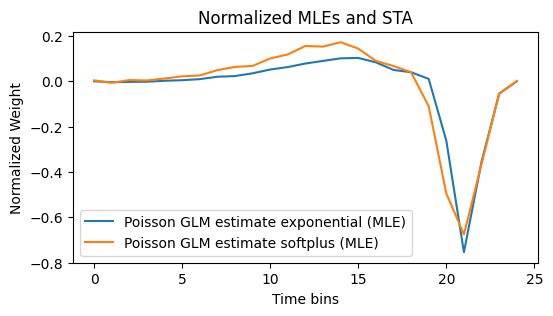

In [14]:
w_mle_softplus_rescaled = w_mle_softplus / np.linalg.norm(w_mle_softplus)

plt.figure(figsize=(6, 3))
plt.plot(w_mle_rescaled[:-1], label='Poisson GLM estimate exponential (MLE)')
plt.plot(w_mle_softplus_rescaled[:-1], label='Poisson GLM estimate softplus (MLE)')
plt.xlabel('Time bins')
plt.ylabel('Normalized Weight')
plt.legend()
plt.title('Normalized MLEs and STA')
plt.show()

**7)** Examine the nonlinearity used by the two Poisson by making a scatter plot of $Xw$ against $f(Xw)$ (where each element of $Xw$ is $\vec x_i \cdot \vec w + b$), for both of the nonlinearities considered above. The x axis label of your plots should be "stimulus filter output" and y axis label output should be "spike rate (sp/bin). If you'd like you can divide the y points by `dtStim` so that the y axis has units of (sp/sec).


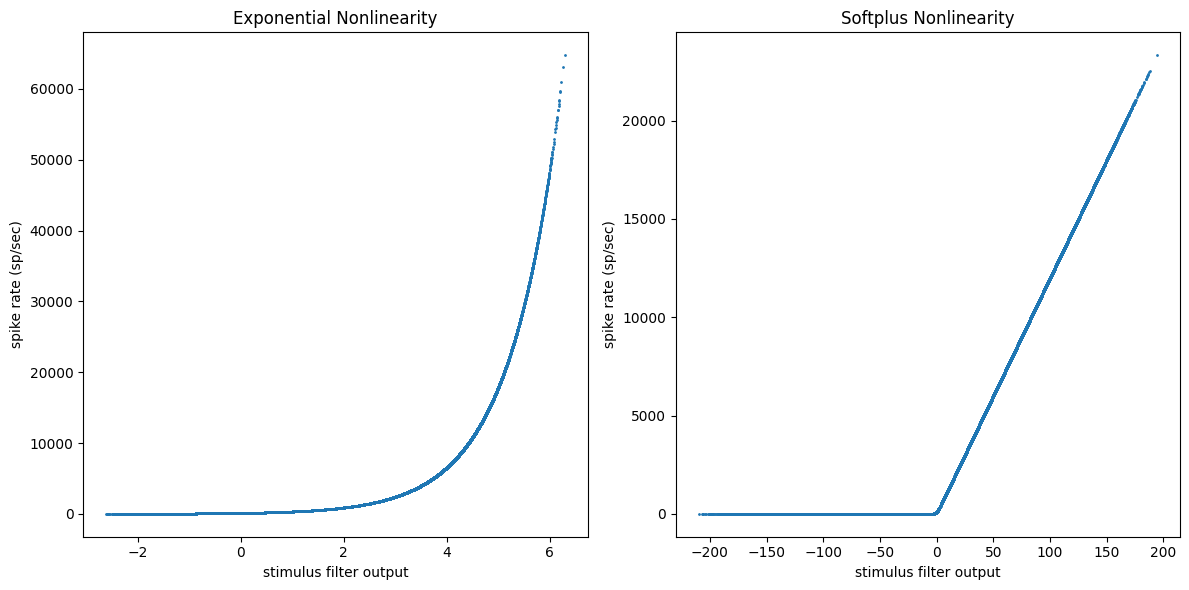

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate Xw
Xw_mle = X @ w_mle[:-1] + w_mle[-1]
Xw_mle_softplus = X @ w_mle_softplus[:-1] + w_mle_softplus[-1]

# Calculate f(Xw) for both nonlinearities
f_Xw_exp = np.exp(Xw_mle)
f_Xw_softplus = np.log(1 + np.exp(Xw_mle_softplus))

# Create scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(Xw_mle, f_Xw_exp / dtStim, s=1)
plt.xlabel('stimulus filter output')
plt.ylabel('spike rate (sp/sec)')
plt.title('Exponential Nonlinearity')

plt.subplot(1, 2, 2)
plt.scatter(Xw_mle_softplus, f_Xw_softplus / dtStim, s=1)
plt.xlabel('stimulus filter output')
plt.ylabel('spike rate (sp/sec)')
plt.title('Softplus Nonlinearity')

plt.tight_layout()
plt.show()

**8)** Now make a non-parametric estimate of the nonlinearity using the method we discussed in class: make a histogram of the values of $Xw$; then, in each histogram compute the average spike count of the stimuli that landed in that bin. Do this separately for each nonlinearity, and make a plot showing the parametric nonlinearity ($\exp(x)$ or $\log(1+\exp(x))$) on the same axes as the histogram-based nonparametric estimate. (I'd recommend using say 25-50 bins for the histogram, though you can experiment with using more or fewer bins to see how this changes the shape of the nonparametric estimate).


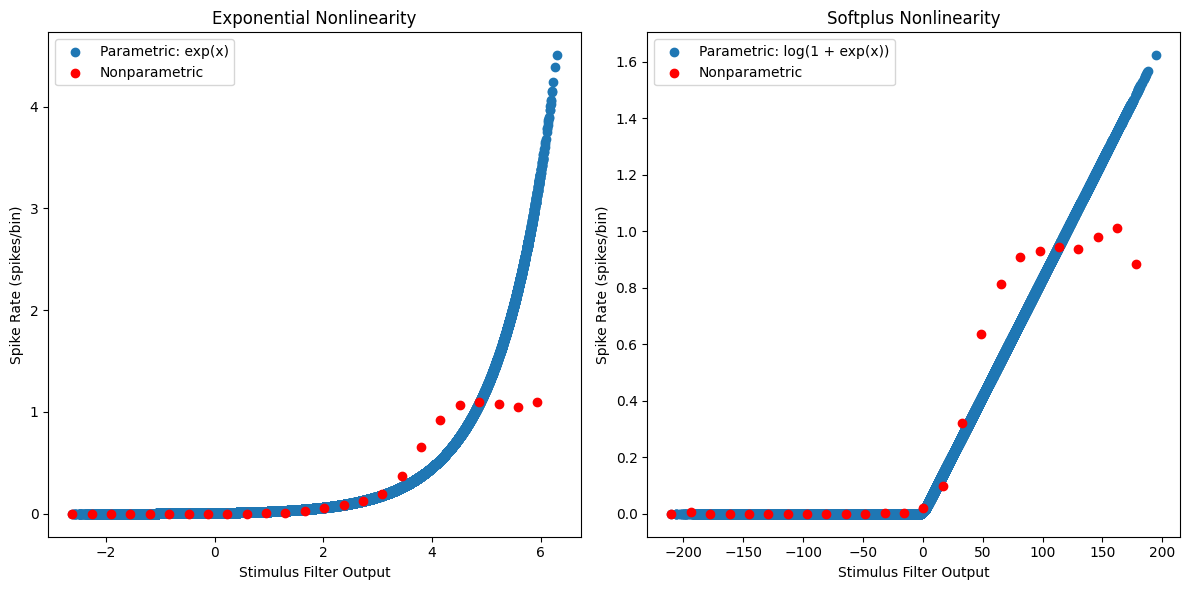

In [16]:
# Computing values of Xw for both nonlinearities
Xw_poisson = X_augmented @ w_mle
Xw_softplus = X_augmented @ w_mle_softplus

# Function to compute the average spike count per bin
def compute_avg_spike_per_bin(Xw, Y, num_bins):
    bin_counts, bin_edges = np.histogram(Xw, bins=num_bins)
    bin_indices = np.digitize(Xw, bin_edges)
    avg_spike_count = np.array([Y[bin_indices == i].mean() for i in range(1, len(bin_edges))])
    return bin_edges, avg_spike_count

# Compute average spike count per bin for each nonlinearity
num_bins = 25
bin_edges_poisson, avg_spike_poisson = compute_avg_spike_per_bin(Xw_poisson, Y, num_bins)
bin_edges_softplus, avg_spike_softplus = compute_avg_spike_per_bin(Xw_softplus, Y, num_bins)

# Plotting
plt.figure(figsize=(12, 6))

# Exponential nonlinearity
plt.subplot(1, 2, 1)
plt.scatter(Xw_poisson, np.exp(Xw_poisson) * dtStim, label='Parametric: exp(x)')
plt.scatter(bin_edges_poisson[:-1], avg_spike_poisson, color='r', label='Nonparametric')
plt.xlabel('Stimulus Filter Output')
plt.ylabel('Spike Rate (spikes/bin)')
plt.title('Exponential Nonlinearity')
plt.legend()

# Softplus nonlinearity
plt.subplot(1, 2, 2)
plt.scatter(Xw_softplus, np.log(1 + np.exp(Xw_softplus)) * dtStim, label='Parametric: log(1 + exp(x))')
plt.scatter(bin_edges_softplus[:-1], avg_spike_softplus, color='r', label='Nonparametric')
plt.xlabel('Stimulus Filter Output')
plt.ylabel('Spike Rate (spikes/bin)')
plt.title('Softplus Nonlinearity')
plt.legend()

plt.tight_layout()
plt.show()


## Adding spike-history to the GLM

**9)** Augment the design matrix $X$ to include 20 bins of spike-history from neuron 1 (i.e. grab the previous 20 time bins of $Y$ for time bin, and insert them into the design matrix). Fit the Poisson-GLM (with exponential nonlinearity) using this larger design matrix. Plot the stimulus filter, and the spike-history filter. How much higher is the log-likelihood of this new model?


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of history bins
history_bins = 20

# Create a new design matrix with spike history
Y_padded = np.pad(Y, (history_bins, 0), mode='constant')

neuron_1_history = Y_padded[0:history_bins]
for i in range(1, X.shape[0]):
    neuron_1_history = np.vstack((neuron_1_history, Y_padded[i:history_bins+i]))
X_with_history = np.hstack([X, neuron_1_history])
X_with_history_augmented = np.hstack((X_with_history, np.ones((X_with_history.shape[0], 1))))

# Fit the Poisson GLM with spike history
w0 = np.zeros(X_with_history_augmented.shape[1])
result = minimize(neg_log_likelihood, w0, args=(Y, X_with_history_augmented))
w_mle_spike_hist = result.x

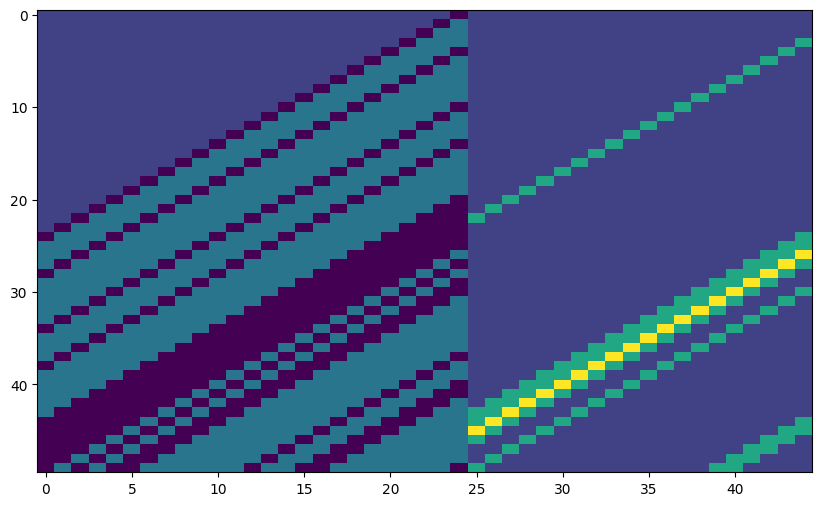

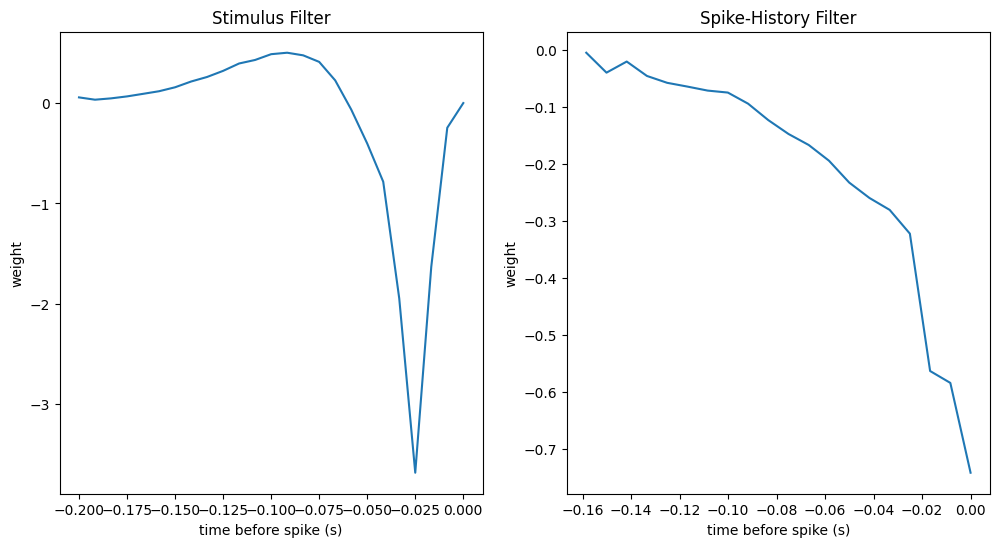

log likelihood for Poisson GLM with spike history: -44832.4368205619
log likelihood for Poisson GLM without spike history: -48430.94685543193
percent difference is 7.430187242904227%


In [18]:
# visualize design matrix
plt.figure(figsize=(10, 6))
plt.imshow(X_with_history[:50, :], aspect='auto', cmap='viridis')


ttk = np.arange(-1*X.shape[1]+1,1)*dtStim # time bins for stim filter
tth = np.arange(-1*history_bins+1,1)*dtStim # time bins for stim filter

# Plot the stimulus filter
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ttk.reshape(X.shape[1],-1), w_mle_spike_hist[0:X.shape[1]])
plt.ylabel('weight')
plt.xlabel('time before spike (s)')
plt.title('Stimulus Filter')

# Plot the spike-history filter (note: the last element is the bias term)
plt.subplot(1, 2, 2)
plt.plot(tth.reshape(history_bins,-1), w_mle_spike_hist[X.shape[1]:-1])
plt.ylabel('weight')
plt.xlabel('time before spike (s)')
plt.title('Spike-History Filter')

plt.show()

log_likelihood_spike_hist = -neg_log_likelihood(w_mle_spike_hist, Y, X_with_history_augmented)
log_likelihood_no_hist = -neg_log_likelihood(w_mle, Y, X_augmented)
print(f"log likelihood for Poisson GLM with spike history: {log_likelihood_spike_hist}")
print(f"log likelihood for Poisson GLM without spike history: {log_likelihood_no_hist}")
print(f"percent difference is {100*(log_likelihood_spike_hist - log_likelihood_no_hist)/-log_likelihood_no_hist}%")

**10)** Now augment the design matrix again to incorporate 20 time-bins of spike history from each of the three other neurons (whose spikes are contained in columns 2 through 4 of `SpCounts`.) Your design matrix now has columns corresponding to the constant $b$, the stimulus filter $w$, the self-coupling spike-history filter $h_1$, and the coupling filters from the other neurons $h_2$, $h_3$, and $h_4$. Compute the maximum likelihood estimate of all parameters of this augmented model, and plot the four filters you obtain. Which coupling filters indicate a positive coupling and which indicate negative coupling? Once again, how much higher is the log-likelihood of this fully coupled model?


In [19]:
from scipy.linalg import hankel

num_cells = 4

all_spike_history = np.zeros((X.shape[0], history_bins, num_cells))
for i in range(num_cells):
    padded_spikes = np.hstack((np.zeros(history_bins), SpCounts[:, i]))
    all_spike_history[:, :, i] = hankel(padded_spikes[0:-history_bins], padded_spikes[-history_bins:])

# reshape
all_spike_history = np.reshape(all_spike_history, (X.shape[0], -1), order='F')
X_with_all_history = np.hstack([X, all_spike_history])
X_with_all_history_augmented = np.hstack((X_with_all_history, np.ones((X_with_all_history.shape[0], 1))))

In [20]:
# fit model
w_all_hist = np.zeros(X_with_all_history_augmented.shape[1])
result = minimize(neg_log_likelihood, w_all_hist, args=(Y, X_with_all_history_augmented))
w_mle_all_spike_hist = result.x

all_spike_hist_stim = w_mle_all_spike_hist[0:25]
all_spike_hist_coupling = []
for i in range(num_cells):
    all_spike_hist_coupling.append(w_mle_all_spike_hist[25+(i*history_bins):25+(i+1)*history_bins])
all_spike_hist_const = w_mle_all_spike_hist[-1]

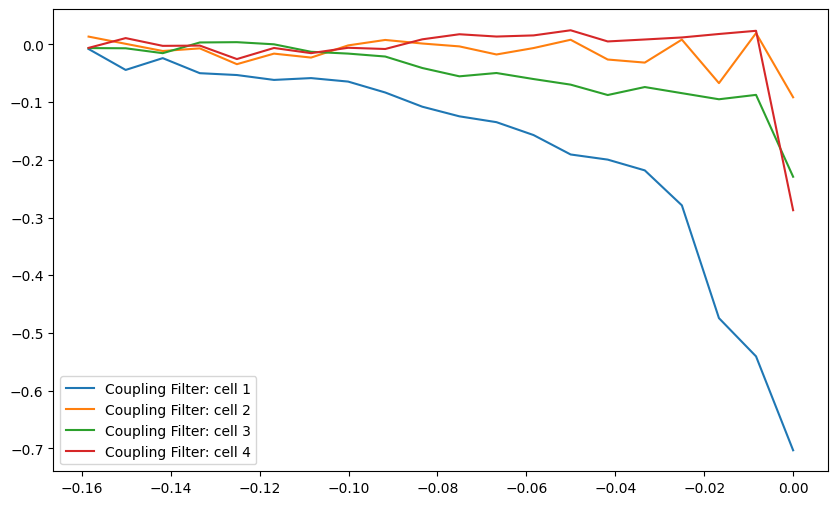

log likelihood for Poisson GLM with all spike history: -44387.58417486273
log likelihood for Poisson GLM without spike history: -48430.94685543193
percent difference is 8.348716973547477%
All coupling filters indicate a negative coupling


In [21]:
plt.figure(figsize=(10, 6))
for i, coupling in enumerate(all_spike_hist_coupling):
    plt.plot(tth.reshape(20,-1), coupling, label=f"Coupling Filter: cell {i+1}")
plt.legend()
plt.show()

log_likelihood_all_spike_hist = -neg_log_likelihood(w_mle_all_spike_hist, Y, X_with_all_history_augmented)
log_likelihood_no_hist = -neg_log_likelihood(w_mle, Y, X_augmented)
print(f"log likelihood for Poisson GLM with all spike history: {log_likelihood_all_spike_hist}")
print(f"log likelihood for Poisson GLM without spike history: {log_likelihood_no_hist}")
print(f"percent difference is {100*(log_likelihood_all_spike_hist - log_likelihood_no_hist)/-log_likelihood_no_hist}%")

print(f"All coupling filters indicate a negative coupling")

**11)** Compute the standard deviation of the output of the stimulus filter (i.e., the relevant columns of $X$ times the fitted stimulus filter $w$) and compare it to the standard deviation of the spike-history filter (the neuron's spike history columns of $X$ multiplied by $h_1$) and the standard deviation of the total output from the three coupling filters. This gives a sense of how large the drive is from each of these three kinds of regressors (stimulus, spike history, and spike-history of other neurons). Make a bar graph showing these three standard deviations you obtained.


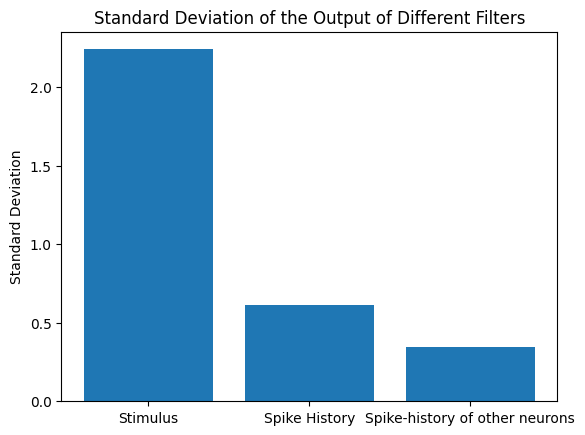

In [22]:
# Compute the standard deviation of the output of the stimulus filter
stim_output = np.dot(X_with_all_history_augmented[:,:25], all_spike_hist_stim)
std_stim = np.std(stim_output)

# Compute the standard deviation of the spike-history filter
spike_hist_output = np.dot(X_with_all_history_augmented[:,25:25+history_bins], all_spike_hist_coupling[0])
std_spike_hist = np.std(spike_hist_output)

# Compute the standard deviation of the total output from the three coupling filters
coupling_output = np.dot(X_with_all_history_augmented[:,25+history_bins:-1], np.reshape(all_spike_hist_coupling[1:], (60,-1)))
std_coupling = np.std(coupling_output)

# Make a bar graph showing these three standard deviations
plt.bar(['Stimulus', 'Spike History', 'Spike-history of other neurons'], [std_stim, std_spike_hist, std_coupling])
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of the Output of Different Filters')
plt.show()

**12)** Repeat the steps in question 10 (fitting the fully coupled model and plotting the filters obtained) but using the Poisson GLM with softplus nonlinearity. Which model achieves higher log-likelihood?


In [23]:
# fit model
w_all_hist_softplus = np.zeros(X_with_all_history_augmented.shape[1])
result = minimize(neg_log_likelihood_softplus, w_all_hist_softplus, args=(Y, X_with_all_history_augmented))
w_mle_all_spike_hist_softplus = result.x

all_spike_hist_stim = w_mle_all_spike_hist_softplus[0:25]
all_spike_hist_coupling_softplus = []
for i in range(num_cells):
    all_spike_hist_coupling_softplus.append(w_mle_all_spike_hist_softplus[25+(i*history_bins):25+(i+1)*history_bins])
all_spike_hist_const_softplus = w_mle_all_spike_hist_softplus[-1]

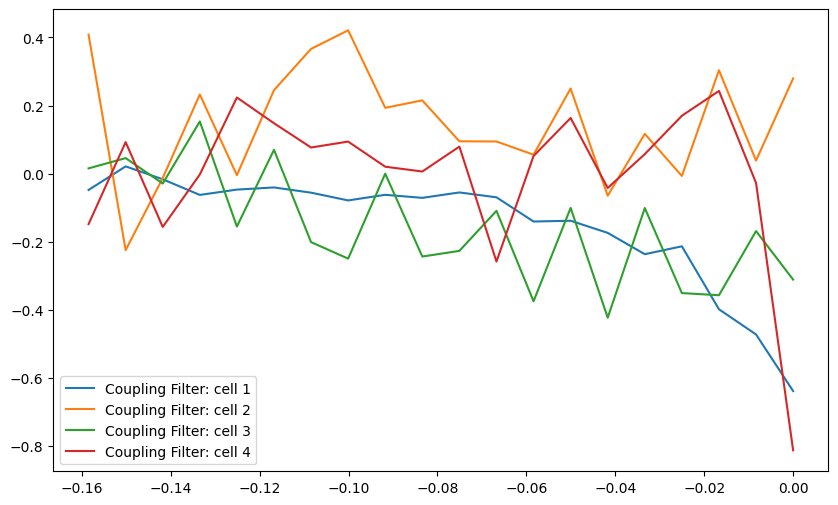

neg log likelihood for Poisson GLM with all spike history using softplus: 43927.366489200984
neg log likelihood for Poisson GLM with all spike history using exponential: 44387.58417486273
percent difference is 198.96318375010287%
self-coupling filter for cell 1 as well as coupling filters for cells 3, and 4, indicate a negative coupling. While coupling filters for cell 2 indicate a slightly positive coupling although the data is quite noisy.
The model using the softplus nonlinearity has a higher log likelihood (lower neg log likelihood) than the model using the exponential nonlinearity.


In [24]:
plt.figure(figsize=(10, 6))
for i, coupling in enumerate(all_spike_hist_coupling_softplus):
    plt.plot(tth.reshape(20,-1), coupling / np.linalg.norm(coupling), label=f"Coupling Filter: cell {i+1}")
plt.legend()
plt.show()

log_likelihood_all_spike_hist_softplus = neg_log_likelihood_softplus(w_mle_all_spike_hist_softplus, Y, X_with_all_history_augmented)
print(f"neg log likelihood for Poisson GLM with all spike history using softplus: {log_likelihood_all_spike_hist_softplus}")
print(f"neg log likelihood for Poisson GLM with all spike history using exponential: {-log_likelihood_all_spike_hist}")
print(f"percent difference is {100*(log_likelihood_all_spike_hist_softplus - log_likelihood_all_spike_hist)/-log_likelihood_all_spike_hist}%")

print(f"self-coupling filter for cell 1 as well as coupling filters for cells 3, and 4, indicate a negative coupling. While coupling filters for cell 2 indicate a slightly positive coupling although the data is quite noisy.")

print(f"The model using the softplus nonlinearity has a higher log likelihood (lower neg log likelihood) than the model using the exponential nonlinearity.")

---

## Regularization

Now load the data contained in `RGCdataHi.mat` and extract the variables `StimHi`, `SpCountHi`, and `dtStimHi`. These variables contain the same stimuli and spike trains analyzed above, but upsampled by a factor of 10 (i.e. so time bins are 10 times smaller). On this timescale the stimuli large temporal correlations because the stimulus values in `StimHi` only change every 10 bins. This means that the stimulus lacks power at high-frequencies, and we will need to regularize. (Note that I truncated these variables to include only the first minute of data from the previous dataset).

**13)** Load the data. Plot the first 1 second of the stimulus and spike train of neuron 1.


In [25]:
#Read in the variables from pdfData2D.mat
from scipy.io import loadmat
data = loadmat('RGCdataHi.mat')
StimHi = data['StimHi']
SpCountsHi = data['SpCountsHi']
dtStimHi = data['dtStimHi']

/var/folders/w2/2lznczgx7xgcld3lkhd_qy380000gn/T/ipykernel_32338/1258650479.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(np.arange(0,1+dtStimHi, dtStimHi), StimHi[:1200], label='Stimulus')
/var/folders/w2/2lznczgx7xgcld3lkhd_qy380000gn/T/ipykernel_32338/1258650479.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(np.arange(0,1+dtStimHi, dtStimHi), SpCountsHi[:1200, 0], label='Spike Train of Neuron 1')


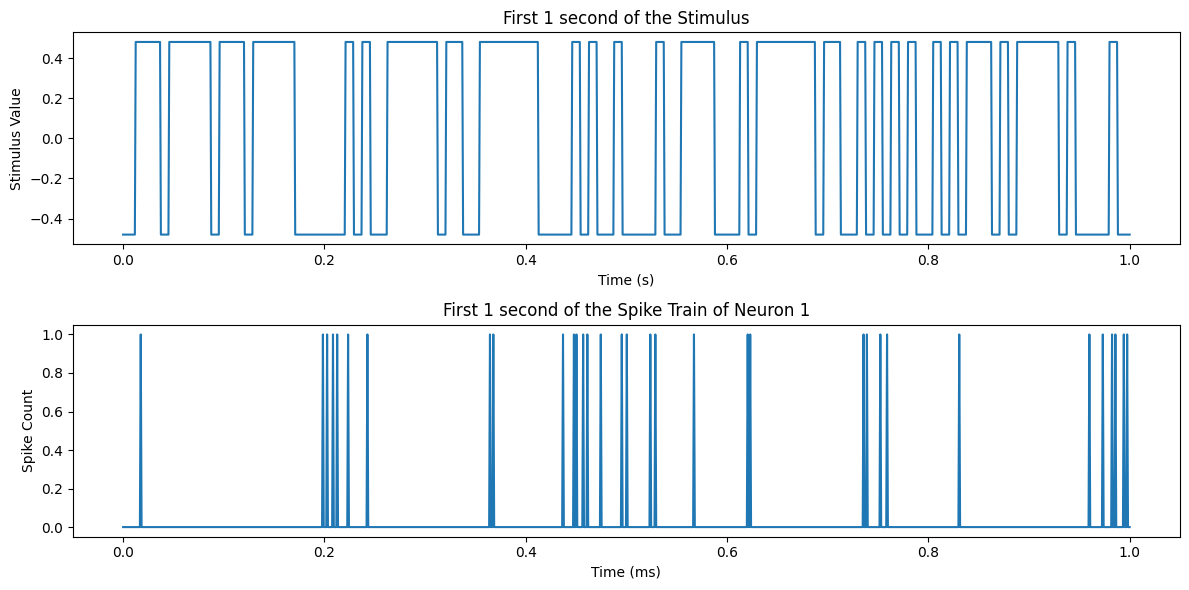

In [26]:
# Plot the first 1 second of the stimulus
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(np.arange(0,1+dtStimHi, dtStimHi), StimHi[:1200], label='Stimulus')
plt.title('First 1 second of the Stimulus')
plt.xlabel('Time (s)')
plt.ylabel('Stimulus Value')

# Plot the first 1 second of the spike train of neuron 1
plt.subplot(2, 1, 2)
plt.plot(np.arange(0,1+dtStimHi, dtStimHi), SpCountsHi[:1200, 0], label='Spike Train of Neuron 1')
plt.title('First 1 second of the Spike Train of Neuron 1')
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')

plt.tight_layout()
plt.show()

**14)** Compute the design matrix for this new dataset (using just the stimulus), now including 250 time bins of the stimulus history. Compute the STA and ML estimate under the linear Gaussian model and plot them on the same axes (rescaled to be unit vectors). Do these look similar?


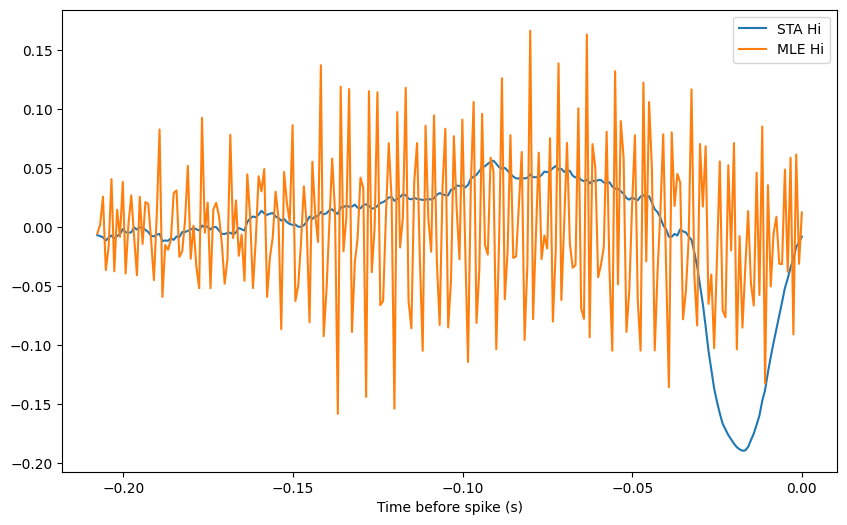

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of time bins
num_bins = 250

StimHi_padded = np.vstack((np.zeros((num_bins-1,1)), StimHi))

XHi = StimHi_padded[0:len(StimHi)]
for i in range(1, num_bins):
    XHi = np.hstack((XHi, StimHi_padded[i:len(StimHi)+i]))
XHi_augmented = np.hstack((XHi, np.ones((XHi.shape[0], 1))))

# Compute the STA
YHi = SpCountsHi[:, 0]
STAHi = np.dot(XHi_augmented.T, YHi) / np.sum(YHi)

# Compute the MLE under the linear Gaussian model
XHiw_mle = np.linalg.inv(XHi_augmented.T @ XHi_augmented) @ XHi_augmented.T @ YHi

# Rescale the STA and MLE to be unit vectors
STA_Hi_rescaled = STAHi / np.linalg.norm(STAHi)
Xw_Hi_mle_rescaled = XHiw_mle / np.linalg.norm(XHiw_mle)

# Plot the STA and MLE
plt.figure(figsize=(10, 6))
ttk = np.arange(-num_bins+1,1)*dtStimHi
plt.plot(np.reshape(ttk, (250,-1)), STA_Hi_rescaled[:-1], label='STA Hi')
plt.plot(np.reshape(ttk, (250,-1)), Xw_Hi_mle_rescaled[:-1], label='MLE Hi')
plt.xlabel('Time before spike (s)')
plt.legend()
plt.show()

Looks really bad :(


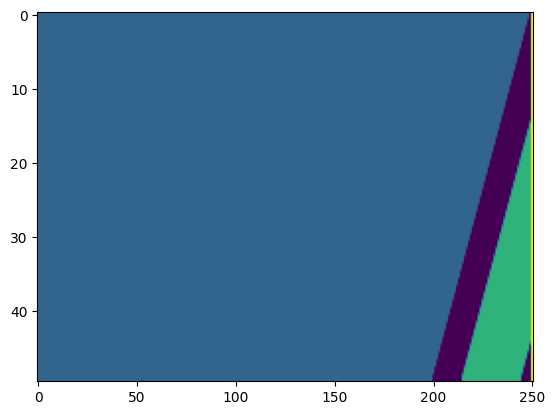

In [28]:
plt.imshow(XHi_augmented[:50, :], aspect='auto', cmap='viridis')

## Ridge regression

**15)** Divide your data into a training set (80%) and test set (20%). Set up a grid of $\lambda$ values ($\lambda_1, \lambda_2, \ldots, \lambda_m)$ and compute the ridge regression estimate of the weights (aka the MAP estimate under a Gaussian prior with covariance $(1/\lambda) I$ for each $\lambda_j$. Can you make a movie showing how $\hat w_{MAP}$ changes with $\lambda$? (If this is too difficult then just make plots showing how the MAP estimate changes with $\lambda$.


In [29]:
train_len = (int) (XHi_augmented.shape[0] * 0.8)

train_design_mat = XHi_augmented[:train_len, :]
test_design_mat = XHi_augmented[train_len:, :]

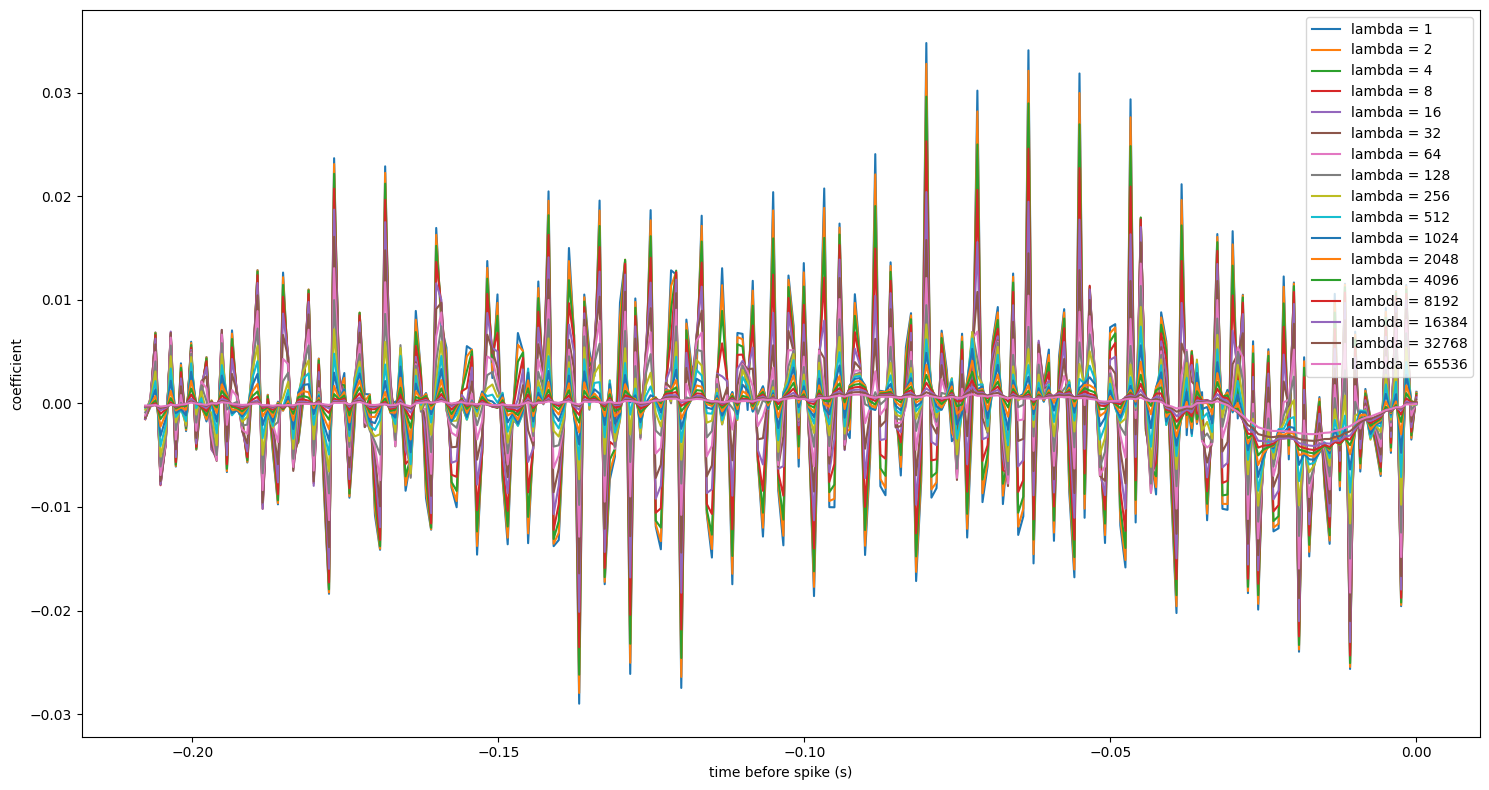

In [30]:
lambda_vals = 2**np.arange(17)
num_lambda = len(lambda_vals)

XX_train = train_design_mat.T @ train_design_mat
XY_train = train_design_mat.T @ YHi[:train_len]

identity_mat = np.identity(train_design_mat.shape[1])
identity_mat[-1, -1] = 0

mse_train = np.zeros(num_lambda)
mse_test = np.zeros(num_lambda)
w_ridge = np.zeros((train_design_mat.shape[1], num_lambda))

fig = plt.figure(figsize=(15, 8))
plt.plot(ttk, ttk*0, c='gray', linestyle='--')
plt.ylabel('coefficient')
plt.xlabel('time before spike (s)')
for id, lambda_val in enumerate(lambda_vals):
    
    w_est = np.linalg.inv(XX_train + lambda_val * identity_mat) @ XY_train
    
    # get MSE
    mse_train[id] = np.mean((train_design_mat @ w_est - YHi[:train_len])**2)
    mse_test[id] = np.mean((test_design_mat @ w_est - YHi[train_len:])**2)
    
    w_ridge[:, id] = w_est
    
    plt.plot(np.reshape(ttk, (250,-1)), w_ridge[:-1, id], label=f'lambda = {lambda_val}')
    
plt.legend()
plt.tight_layout()
plt.show()

**16)** To determine the optimal value of $\lambda$, make a plot of the test-error-per-sample, $||Y_{test}- X_{test} \hat w||^2$ divided by the number of bins in the test set, as a function of $\lambda$. Make sure your $\lambda$ range is wide enough to capture a few values on either side of the global minimum. (Note that this differs slightly from what we discussed in class, which was plotting test _log-likelihood_, but with Gaussian noise model it is fairly common to compute mean squared error, which is (after all) just a scaled version of the negative of the log-likelihood). On the same axes, plot the training error per sample. Do these curves have the same shape we discussed in class?


Text(0.5, 1.0, 'train-error-per-sample error')

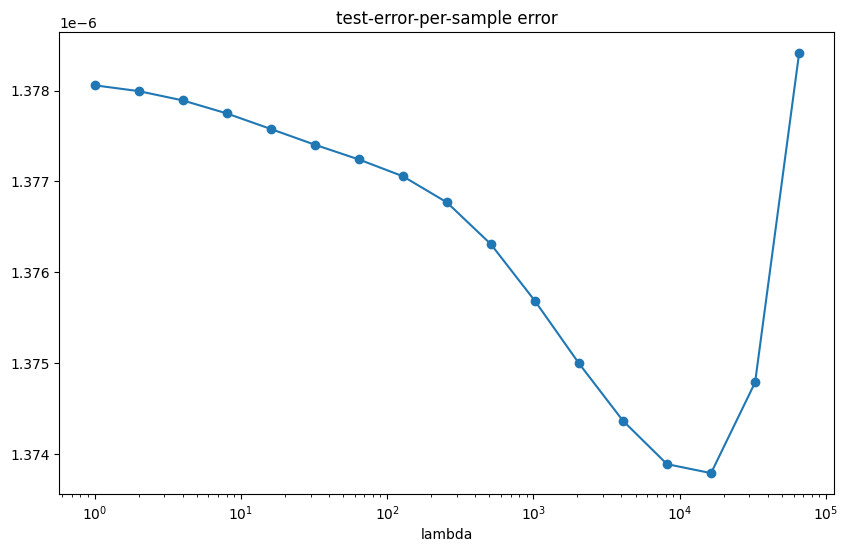

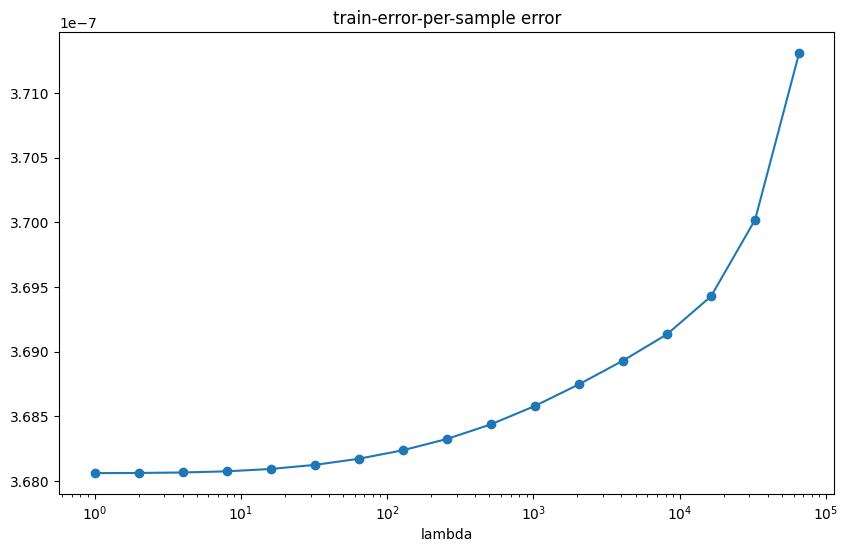

In [31]:
bins_in_test_set = test_design_mat.shape[0]
bins_in_train_set = train_design_mat.shape[0]

fig = plt.figure(figsize=(10, 6))
plt.xlabel('lambda')
plt.title('test-error-per-sample error')
plt.xscale('log')
plt.plot(lambda_vals, mse_test / bins_in_test_set, 'o-', label='test error per sample')

fig = plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, mse_train / bins_in_train_set, 'o-', label='train error per sample')
plt.xscale('log')
plt.xlabel('lambda')
plt.title('train-error-per-sample error')

Yes! These curves show the tradeoff between high and low lambda values


## Smoothing regularization

**17)** Generate the $250\times 250$ graph Laplacian matrix $L$ that computes the sum of squared differences in $\vec w$ via $\vec w^T L \vec w$.

Verify that when you generate a random $\vec w$ vector, you get the same value if you compute $\sum_{i=2}^{250} (w_i-w_{i-1})^2$ as $\vec w^T L \vec w$


In [32]:
# Generate the 250x250 graph Laplacian matrix L
L = np.zeros((250, 250))
for i in range(0, 250-1):
    L[i, i] = 2
    L[i, i+1] = -1
    L[i+1, i] = -1
L[0, 0] = 1
L[-1,-1] = 1

# Generate a random w vector
w = np.random.rand(250)

# Compute sum of squared differences in w
sum_sq_diff = np.sum(np.diff(w)**2)

# Compute w^T L w
wT_L_w = w.T @ L @ w

print("Sum of squared differences in w: ", sum_sq_diff)
print("w^T L w: ", wT_L_w)


Sum of squared differences in w:  41.46493166504713
w^T L w:  41.46493166504713


**18)** Now repeat the steps you took in problems 15-16 to perform cross-validation under the smoothing prior for a grid of different $\lambda$ values, where (now) the inverse covariance matrix is given by $\lambda L$. Plot the curve of test error per sample and training error per sample as a function of $\lambda$, and plot a few of the $\hat w_{map}$ estimates, one below the minimum, one at the minimum, and one above the minimum of the test error curve. Which estimate achieves a better estimate in terms of test error, the optimal ridge prior estimate or the optimal smoothing prior estimate?


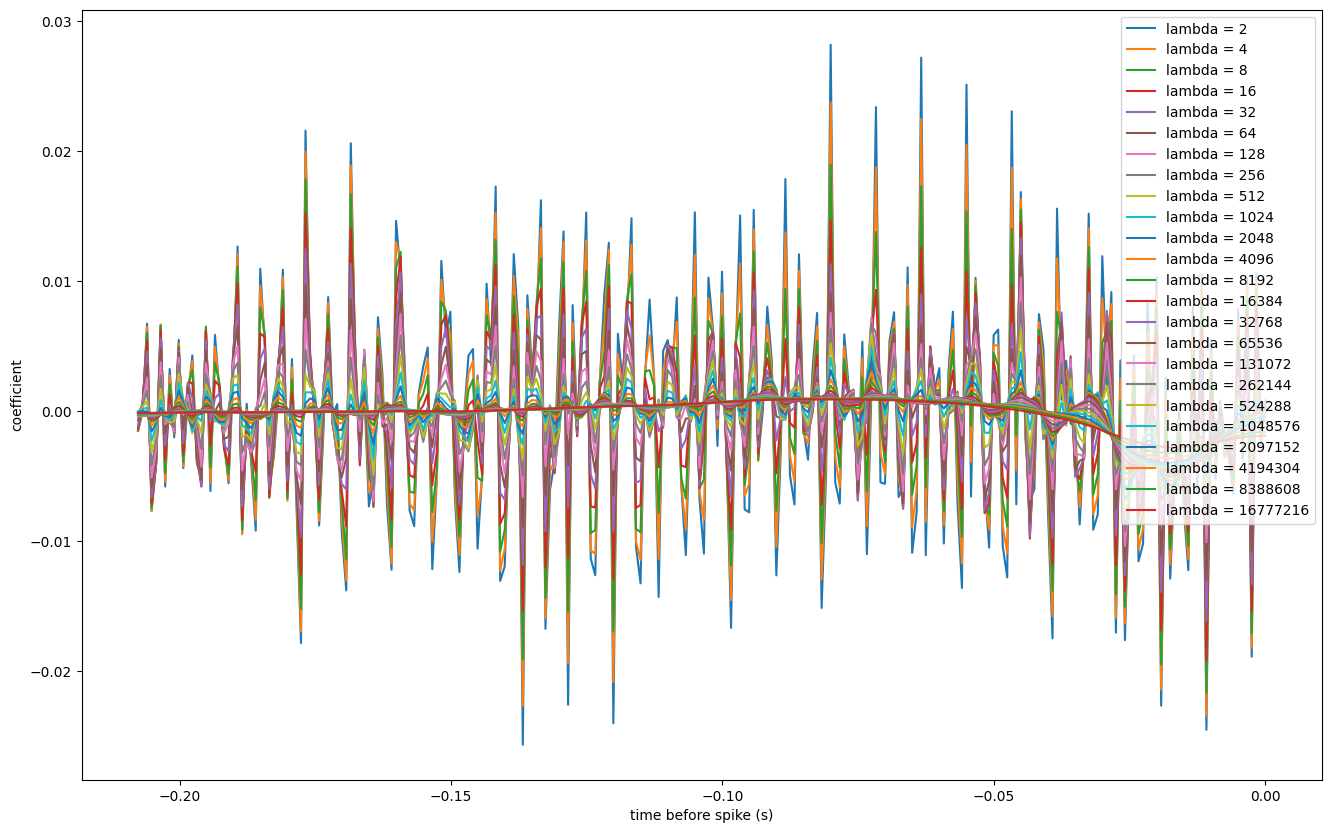

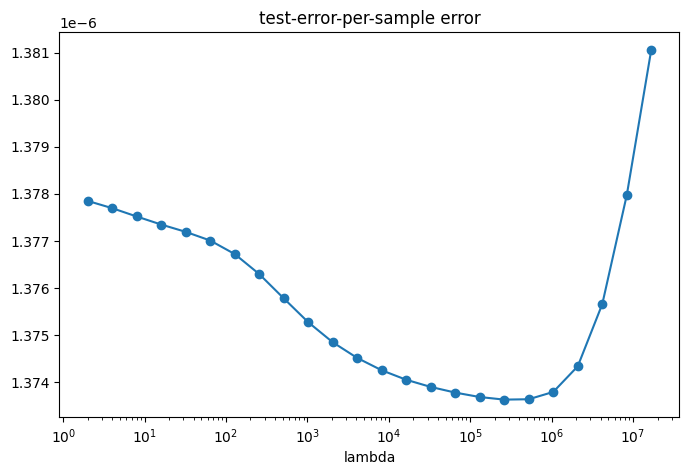

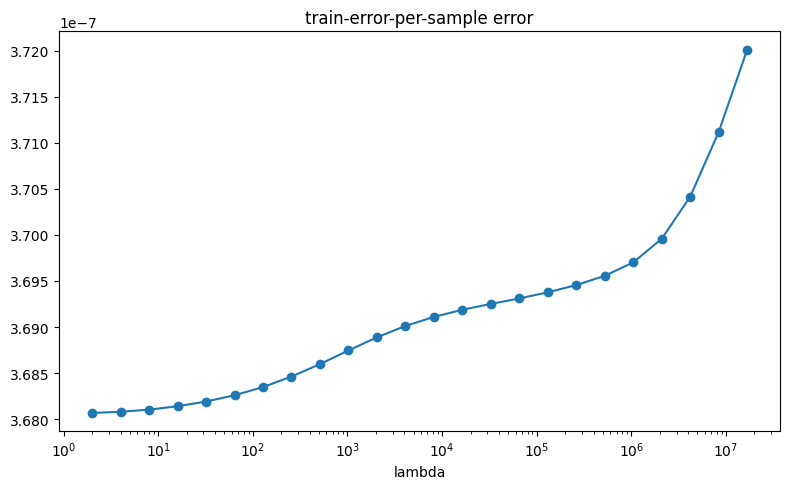

In [33]:
import scipy

L_augmented = scipy.linalg.block_diag(L, 0)

lambda_vals = 2**np.arange(1,25,1)
num_lambda = len(lambda_vals)

mse_train_smooth = np.zeros(num_lambda)
mse_test_smooth = np.zeros(num_lambda)
w_smooth = np.zeros((train_design_mat.shape[1], num_lambda))

fig = plt.figure(figsize=(16, 10))
plt.plot(ttk, ttk*0, c='gray', linestyle='--')
plt.ylabel('coefficient')
plt.xlabel('time before spike (s)')
for id, lambda_val in enumerate(lambda_vals):
    
    w_est = np.linalg.inv(XX_train + lambda_val * L_augmented) @ XY_train
    
    # get MSE
    mse_train_smooth[id] = np.mean((train_design_mat @ w_est - YHi[:train_len])**2)
    mse_test_smooth[id] = np.mean((test_design_mat @ w_est - YHi[train_len:])**2)
    
    w_smooth[:, id] = w_est
    
    plt.plot(np.reshape(ttk, (250,-1)), w_smooth[:-1, id], label=f'lambda = {lambda_val}')
    
plt.legend()

bins_in_test_set = test_design_mat.shape[0]
bins_in_train_set = train_design_mat.shape[0]

fig = plt.figure(figsize=(8, 5))
plt.xlabel('lambda')
plt.title('test-error-per-sample error')
plt.xscale('log')
plt.plot(lambda_vals, mse_test_smooth / bins_in_test_set, 'o-', label='test error per sample')

fig = plt.figure(figsize=(8, 5))
plt.plot(lambda_vals, mse_train_smooth / bins_in_train_set, 'o-', label='train error per sample')
plt.xscale('log')
plt.xlabel('lambda')
plt.title('train-error-per-sample error')

plt.tight_layout()
plt.show()

**18)** Now repeat the steps you took in problems 15-16 to perform cross-validation under the smoothing prior for a grid of different $\lambda$ values, where (now) the inverse covariance matrix is given by $\lambda L$. Plot the curve of test error per sample and training error per sample as a function of $\lambda$, and plot a few of the $\hat w_{map}$ estimates, one below the minimum, one at the minimum, and one above the minimum of the test error curve. Which estimate achieves a better estimate in terms of test error, the optimal ridge prior estimate or the optimal smoothing prior estimate?


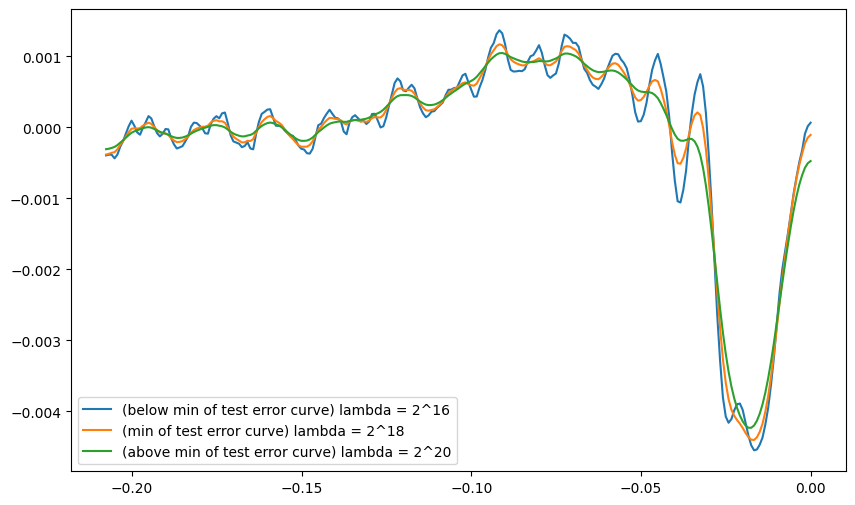

In [34]:
min_index = np.argmin(mse_test_smooth)
below_min_index = np.argmin(mse_test_smooth)-2
above_min_index = np.argmin(mse_test_smooth)+2

w_map_min_error = w_smooth[:, min_index]
w_map_below_min_error = w_smooth[:, below_min_index]
w_map_above_min_error = w_smooth[:, above_min_index]

plt.figure(figsize=(10, 6))
plt.plot(np.reshape(ttk, (250,-1)), w_map_below_min_error[:-1], label='(below min of test error curve) lambda = 2^'+str(below_min_index+1))
plt.plot(np.reshape(ttk, (250,-1)), w_map_min_error[:-1], label='(min of test error curve) lambda = 2^'+str(min_index+1))
plt.plot(np.reshape(ttk, (250,-1)), w_map_above_min_error[:-1], label='(above min of test error curve) lambda = 2^'+str(above_min_index+1))
plt.legend()
plt.show()

In [35]:
min_index_ridge = np.min(mse_test)
min_index_smooth = np.min(mse_test_smooth)

print(f"Minimum test error for ridge regression: {min_index_ridge}")
print(f"Minimum test error for smoothness prior: {min_index_smooth}")
print(f"Smoothness prior has lower test error so it is the better estimate.")

Minimum test error for ridge regression: 0.019782567962064384
Minimum test error for smoothness prior: 0.01978015645220798
Smoothness prior has lower test error so it is the better estimate.
